In [1]:
import numpy as np
import mat73
import pandas as pd
from hyperopt import tpe
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from scipy.signal import filtfilt,butter,hilbert,convolve2d,convolve
import scipy.io as sio
from Bolu_IFG.utils import *
import nltk
from nltk.stem import WordNetLemmatizer
import hyperopt
import collections
import gensim.downloader as word2vec
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC,SVC,SVR
from sklearn.decomposition import PCA,KernelPCA
from sklearn.neighbors import NeighborhoodComponentsAnalysis as NCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cross_decomposition import PLSSVD,PLSRegression,PLSCanonical,CCA
import enlighten
from torchtext import vocab as Vocab
from Bolu_IFG.AlignNet import AlignmentNet
from sklearn.manifold import TSNE
from tqdm import tqdm

from nltk.metrics import aline
# Download the CMU Pronouncing Dictionary
nltk.download('cmudict')
# Create a sentence to phoneme dictionary

words_to_phonemes = nltk.corpus.cmudict.dict()

C:\Users\Owner\miniconda3\envs\Speech\lib\site-packages\torchtext\vocab\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
C:\Users\Owner\miniconda3\envs\Speech\lib\site-packages\torchtext\utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
[nltk_data] Downloading package cmudict to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package 

In [2]:
band='spike_band' ## this could be high gamma band or spike band
date = 'Jan05_2024'  # here we have Jan05_2024,
raw_data_jan = get_raw(date, band)
date = 'Dec06_2023'  # here we have Jan05_2024, Dec06_2023 data
raw_data_dec = get_raw(date, band)


rejected_channels: [ 3 62] 

rejected_trials: [ 32  64  65  91 103 108 109 110 111 112 130 246 281]


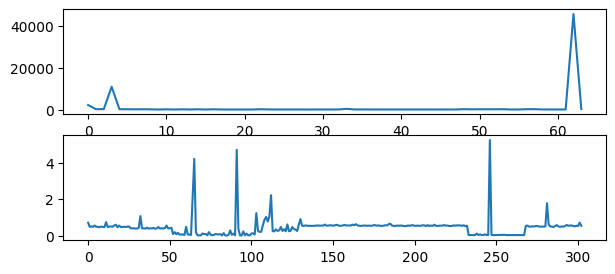

In [3]:
# concatenate data
raw_data = pd.concat([raw_data_jan,raw_data_dec])
# clean the data
raw_data,reject_channels,reject_trials,channel_std,trial_std = data_cleaning(raw_data)
print(f"rejected_channels: {reject_channels} \n")
print(f"rejected_trials: {reject_trials}")

clean_data=[np.delete(a,reject_channels,axis=0) for a in raw_data[1].to_list()]

fig,ax=plt.subplots(2,1,figsize=(7,3))
ax[0].plot(channel_std)
ax[1].plot(trial_std)
plt.show()

In [4]:
# process the labels
correct_label = raw_data[10].to_numpy()
answered_label = raw_data[11].to_numpy()
answered_words = raw_data[8].to_numpy()
answered_semantic_label=raw_data[12].to_numpy()
correct_label = np.array([a[0] for a in correct_label])
answered_label = np.array([a[0] for a in answered_label])
answered_semantic_label=np.array([a[0] if a!=np.NaN else np.NaN for a in answered_semantic_label])
lemmatizer = WordNetLemmatizer()
answered_lexical_item = np.array([lemmatizer.lemmatize(a[0][0][0], pos='v') for a in answered_words])
first_phonemes = np.array([words_to_phonemes[a][0][0] for a in answered_lexical_item])

# process the time stamps
phrase_on = raw_data[2].to_numpy()
word_on = raw_data[4].to_numpy()
voice_on = raw_data[6].to_numpy()
voice_off = raw_data[7].to_numpy()

phrase_on = np.array([a[0][0] for a in phrase_on])
word_on = np.array([a[0][0] for a in word_on])
voice_on = np.array([a[0][0] for a in voice_on])
voice_off = np.array([a[0][0] for a in voice_off])

# recording frequency rate
fs = 2000
print(collections.Counter(answered_lexical_item))
print(collections.Counter(answered_semantic_label))
print(collections.Counter(first_phonemes))
print(collections.Counter(answered_label))

Counter({'rub': 22, 'tip': 22, 'bake': 16, 'pack': 15, 'keep': 14, 'boot': 14, 'date': 13, 'call': 12, 'pass': 12, 'talk': 12, 'dock': 11, 'rap': 11, 'cry': 7, 'run': 6, 'chew': 5, 'fail': 5, 'snore': 5, 'look': 5, 'grab': 5, 'wipe': 5, 'jump': 4, 'kick': 4, 'need': 4, 'vote': 4, 'lick': 4, 'star': 3, 'yell': 3, 'cut': 3, 'heal': 3, 'bite': 3, 'peek': 3, 'mix': 3, 'chase': 3, 'stare': 3, 'kiss': 3, 'punch': 2, 'see': 2, 'write': 2, 'hop': 2, 'load': 1, 'walk': 1, 'type': 1})
Counter({'h': 74, 'a': 58, 'o': 56, 'm': 55, 'l': 19, 'e': 16})
Counter({'K': 43, 'R': 41, 'T': 35, 'B': 33, 'P': 32, 'D': 24, 'S': 13, 'L': 10, 'CH': 8, 'W': 6, 'F': 5, 'HH': 5, 'G': 5, 'JH': 4, 'N': 4, 'V': 4, 'Y': 3, 'M': 3})
Counter({'2': 135, '1': 79, '3': 64})


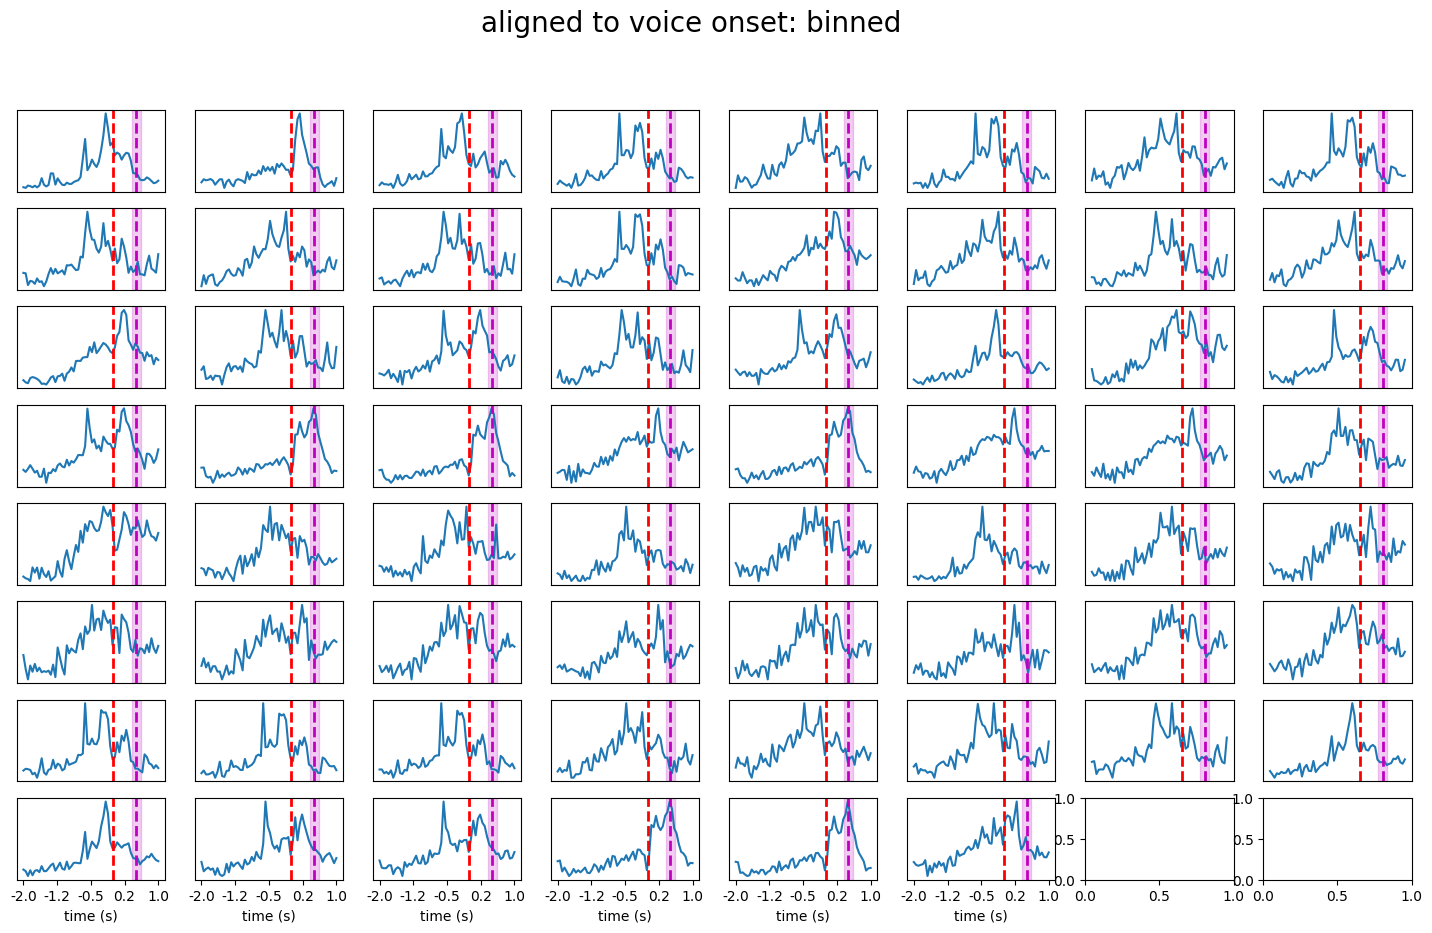

In [5]:
# define the decoding time range and bin the data
# aligning to the voice onset

back=2 # looking back 3 seconds before onset
forward=1 # looking forward 1 second after onset
bin_size=0.05 # s
adjusted_fs=1/bin_size # Hz
processed_data_voice_on=[trial[:,int(voice_on[i]*fs-back*fs) : int(voice_on[i]*fs+forward*fs)] for i,trial in enumerate(clean_data)]
n_channels=processed_data_voice_on[0].shape[0]
n_trials_total=len(processed_data_voice_on)
binned_data_voice_on=[trial.reshape(n_channels,int(bin_size*fs),-1,order='F').mean(axis=1) for trial in processed_data_voice_on]
binned_data_voice_on_averaged=np.mean(binned_data_voice_on,axis=0)
n_bins=binned_data_voice_on_averaged.shape[-1]

ave_voice_on=back

ave_phrase_on=-(voice_on-phrase_on).mean()+ave_voice_on
std_phrase_on=(voice_on-phrase_on).std()

ave_word_on=-(voice_on-word_on).mean()+ave_voice_on
std_word_on=(voice_on-word_on).std()

ave_voice_off=-(voice_on-voice_off).mean()+ave_voice_on
std_voice_off=(voice_off-voice_on).std()

fig,ax=plt.subplots(8,8,figsize=(18,10))
for i in range(n_channels):
    ax[i//8,i%8].plot(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),binned_data_voice_on_averaged[i])
    ax[i//8,i%8].set_yticks([])
    if i//8!=7:   
        ax[i//8,i%8].set_xticks([])
    else:
        ax[i//8,i%8].set_xticks(np.linspace(0,(back+forward)*adjusted_fs,5), [f"{i:0.1f}" for i in np.linspace(-back,forward,5)])
        ax[i//8,i%8].set_xlabel("time (s)")
    
    ax[i//8,i%8].axvspan(ave_voice_off * adjusted_fs - std_voice_off * adjusted_fs, ave_voice_off * adjusted_fs + std_voice_off * adjusted_fs, color='m', alpha=0.2)
    #ax[i//8,i%8].axvspan(ave_word_on * adjusted_fs - std_word_on * adjusted_fs, ave_word_on * adjusted_fs + std_word_on * adjusted_fs, color='g', alpha=0.2)
    #ax[i//8,i%8].axvline(ave_word_on * adjusted_fs, color='g', linestyle='--', linewidth=2)
    ax[i//8,i%8].axvline(ave_voice_on * adjusted_fs, color='r', linestyle='--', linewidth=2)
    ax[i//8,i%8].axvline(ave_voice_off * adjusted_fs, color='m', linestyle='--', linewidth=2)
plt.suptitle("aligned to voice onset: binned",fontsize=20)
plt.show()

# here we would like to do regression between the neural signal to word embeddings ()

In [6]:
# two ways of doing it
# for semantic embeddings: use the original form (this may be easier to find the embedding)

# for whole word phonetic embeddings: use the answered form

#phoneme_embed='ALINE' 
embed=word2vec.load('word2vec-google-news-300')
#embed = Vocab.GloVe(dim='300',name='840B')  # TODO: here we are only using the standard pretrained model
#embed=Vocab.FastText(language='simple')


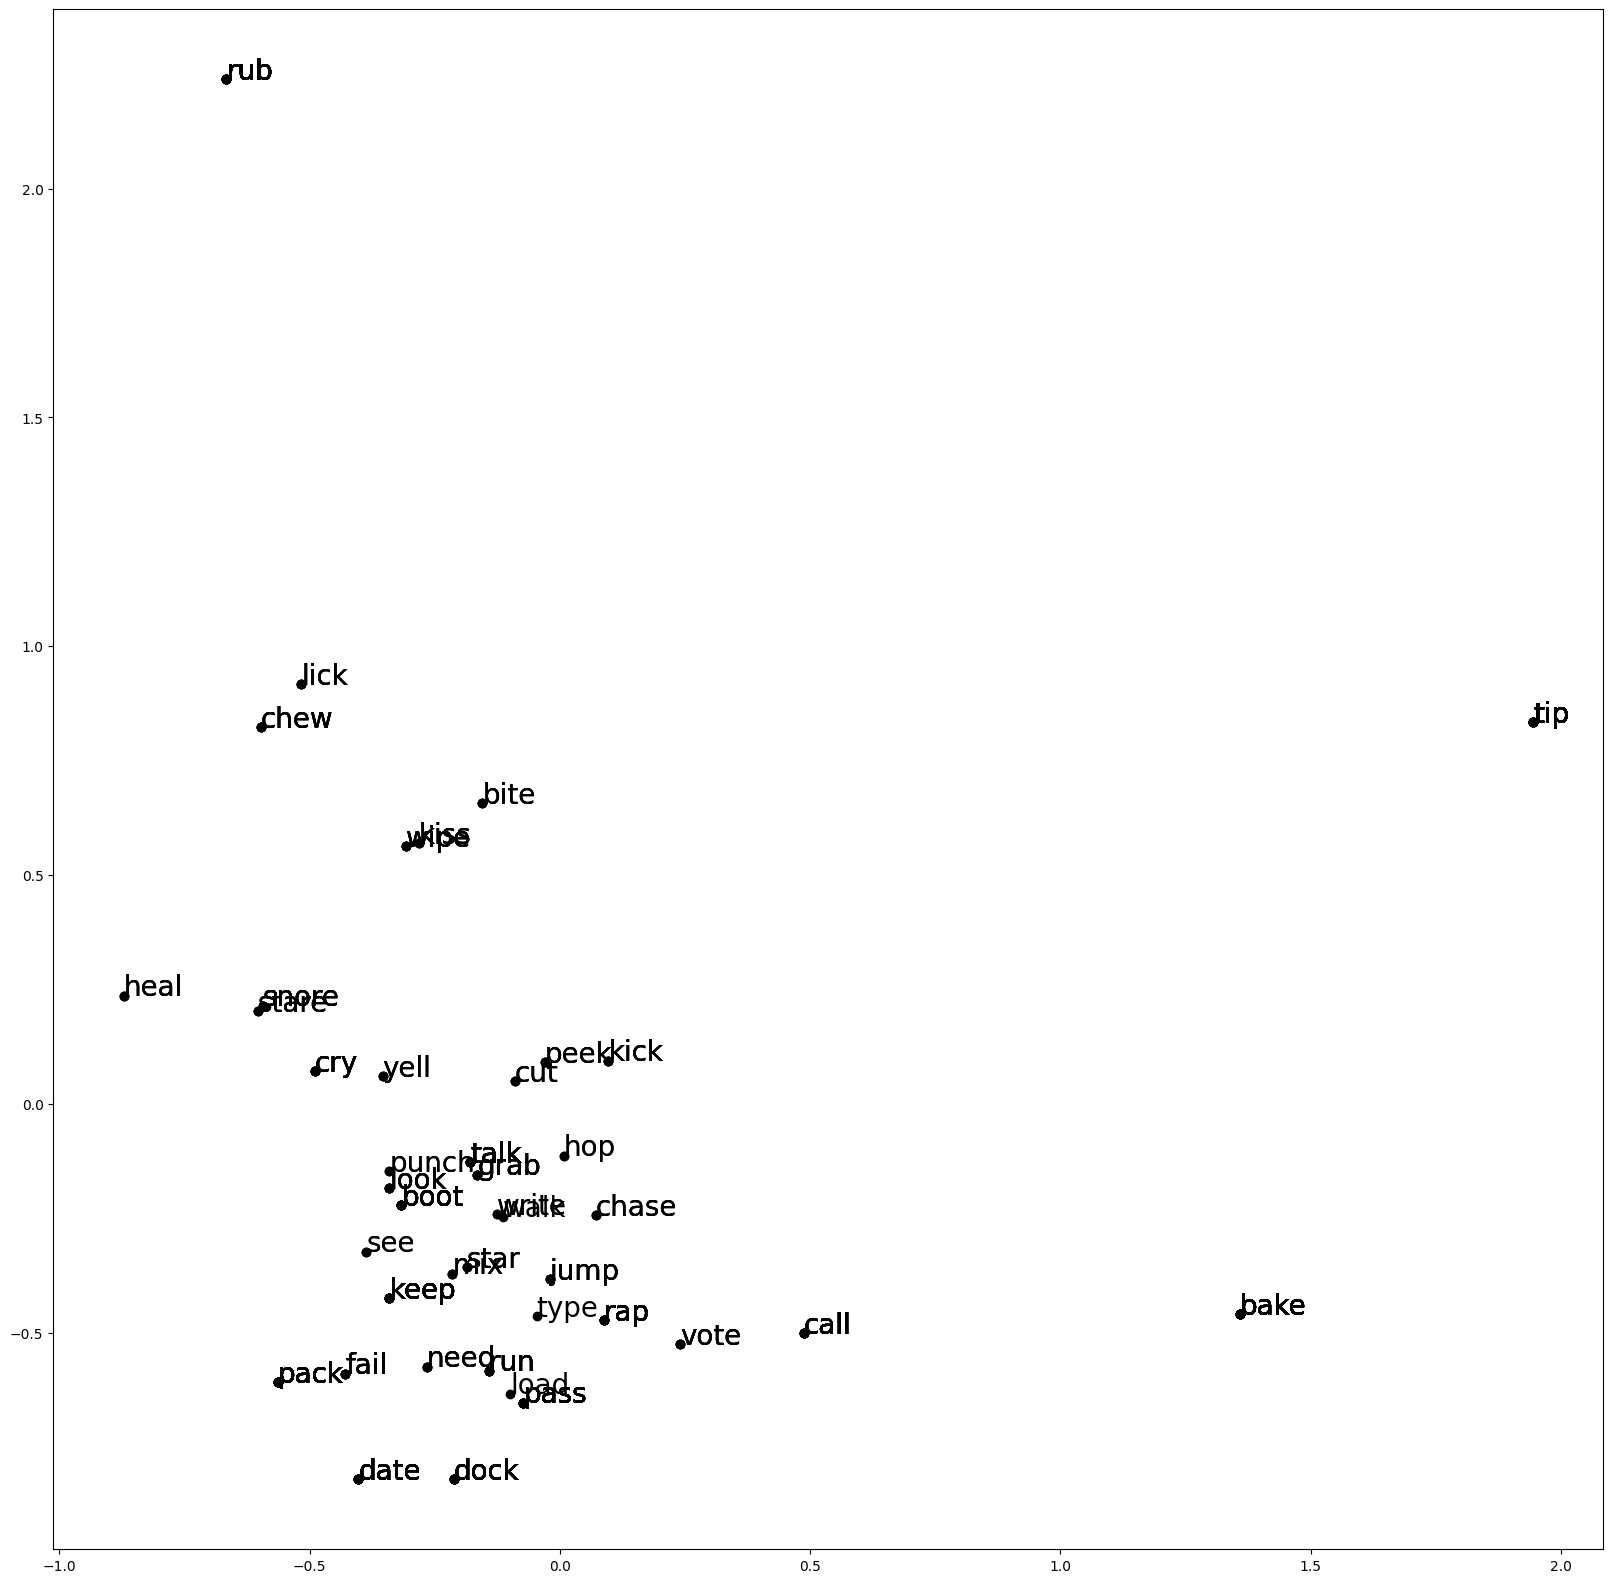

In [7]:
answered_words_=[a[0][0][0] for a in answered_words]
word_embed=[embed[a] for a in answered_lexical_item]
low_D_word_embed=PCA(n_components=3).fit_transform(np.array(word_embed))

fig,ax=plt.subplots(1,1,figsize=(20,20))
for i,w in enumerate(low_D_word_embed):
    ax.scatter(w[2],w[1],color='k')
    ax.text(w[2],w[1],answered_lexical_item[i],fontsize=20)
    
plt.show()

In [8]:
data_to_use=np.array(binned_data_voice_on).swapaxes(1,2)
embedding_to_use= PCA(n_components=40).fit_transform(np.array(word_embed))

# np.save(f"../Bolu_IFG/data_to_use.npy",data_to_use)
# np.save(f"../Bolu_IFG/embedding_to_use.npy",embedding_to_use)

In [12]:
# Here we are trying to do some regression task. It's shown that the dataset m
preprocess_dim=40

### preprocesing 
preprocessor=PCA(n_components=preprocess_dim)

# define how many bins we want in each feature
n_bins_per_feature=10

# reformat the data: for each time bin we include n_bins_per_feature of history
X=reformat(data_to_use,n_bins_per_feature) # data is a list

#### Start decoding
n_repeat=20
averaged_score=[]
averaged_chance=[]
# GUI for process visualization
manager = enlighten.get_manager()
#ticks = manager.counter(total=n_repeat, desc="Num. repeat", unit="repeats", color="red")

for j in tqdm(range(n_repeat), desc='repeats', unit='rep.'):
    score=[]
    chance=[]
    for n_bin in tqdm(range(len(X)),leave=False,desc='bins',unit='bin'):
        # sample the train and test set
        X_train, X_test, y_train, y_test =get_train_test(X[n_bin],embedding_to_use,train=0.8)
        
        # decrease the dimension
        preprocessor.fit(X_train)
        X_train_low_D=preprocessor.transform(X_train)
        X_test_low_D=preprocessor.transform(X_test)
        

        extractor=AlignmentNet(n_features=X_train_low_D.shape[1],
                               n_targets=y_train.shape[1],n_low_D=8)  
        
        X_train_low_D=(X_train_low_D-np.mean(X_train_low_D))/np.std(X_train_low_D)
        X_test_low_D=(X_test_low_D-np.mean(X_test_low_D))/np.std(X_test_low_D)
        y_train=(y_train-np.mean(y_train))/np.std(y_train)
        y_test=(y_test-np.mean(y_test))/np.std(y_test)
        # do the regression(alignment)  
        extractor.fit(X_train_low_D,y_train,lambda_l1=0.0002,num_iterations=200)
        sc=extractor.score(X_test_low_D,y_test)
        
        np.random.shuffle(X_train_low_D.T)
        np.random.shuffle(y_train.T)
        extractor.fit(X_train_low_D,y_train,lambda_l1=0.0002,num_iterations=200)
        ch=extractor.score(X_test_low_D,y_test)
        
        score.append(sc)
        chance.append(ch)
    #ticks.update()
    averaged_score.append(score)
    averaged_chance.append(chance)
     

repeats: 100%|██████████| 20/20 [43:38<00:00, 130.90s/rep.]


In [13]:
alpha = 2.5
#percentile_bybin = np.percentile(averaged_accuracy,alpha,axis=0)
#p_illustration=['*' if 0.05<percentile_bybin[i] else '' for i in range(n_bins)]

percentile_bybin = np.percentile(averaged_score,alpha,axis=0)
p_illustration=['*' if percentile_bybin[i]>0 else '' for i in range(n_bins)]

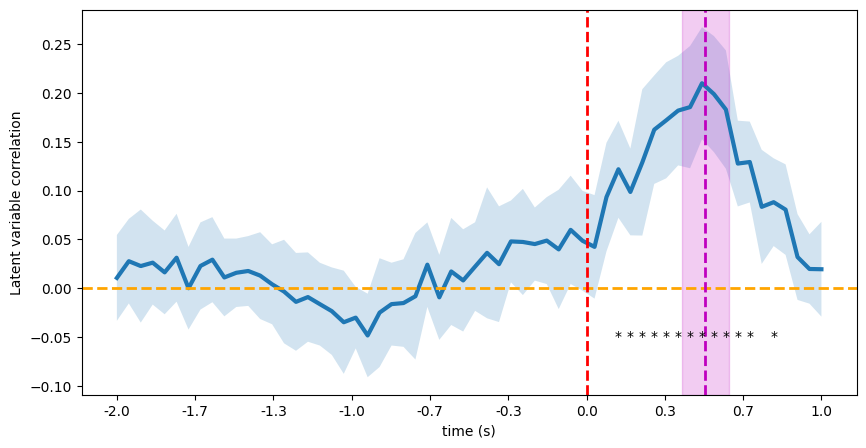

In [14]:
fig,ax=plt.subplots(1,1,figsize=(10,5))

ax.plot(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),np.mean(averaged_score,axis=0),lw=3)
#ax.plot(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),np.mean(averaged_chance,axis=0),lw=2,linestyle='--',color='orange')
ax.fill_between(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),
                np.mean(averaged_score,axis=0)-np.std(averaged_score,axis=0),
               np.mean(averaged_score,axis=0)+np.std(averaged_score,axis=0),alpha=0.2)
ax.axhline(0,lw=2,linestyle='--',color='orange')

#ax.boxplot(averaged_accuracy_.T,positions=np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),showfliers=False)
#ax2=ax.twinx()
#ax2.plot(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),binned_data_voice_on_averaged.mean(axis=0),c='grey',linestyle='--')
ax.axvspan(ave_voice_off * adjusted_fs - std_voice_off * adjusted_fs, ave_voice_off * adjusted_fs + std_voice_off * adjusted_fs, color='m', alpha=0.2)
# ax.axvspan(ave_word_on * adjusted_fs - std_word_on * adjusted_fs, ave_word_on * adjusted_fs + std_word_on * adjusted_fs, color='g', alpha=0.2)
# ax.axvline(ave_word_on * adjusted_fs, color='g', linestyle='--', linewidth=2)
ax.axvline(ave_voice_on * adjusted_fs, color='r', linestyle='--', linewidth=2)
ax.axvline(ave_voice_off * adjusted_fs, color='m', linestyle='--', linewidth=2)
ax.set_xticks(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),10), [f"{i:0.1f}" for i in np.linspace(-back,forward,10)])
#ax.set_ylim([-2,1])
ax.set_xlabel("time (s)")
ax.set_ylabel("Latent variable correlation")
for label, loc in zip(p_illustration,np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins)):
    ax.text(loc, -0.05, label, ha='center', va='center')

plt.show()

NameError: name 'binned_data_phrase_on' is not defined

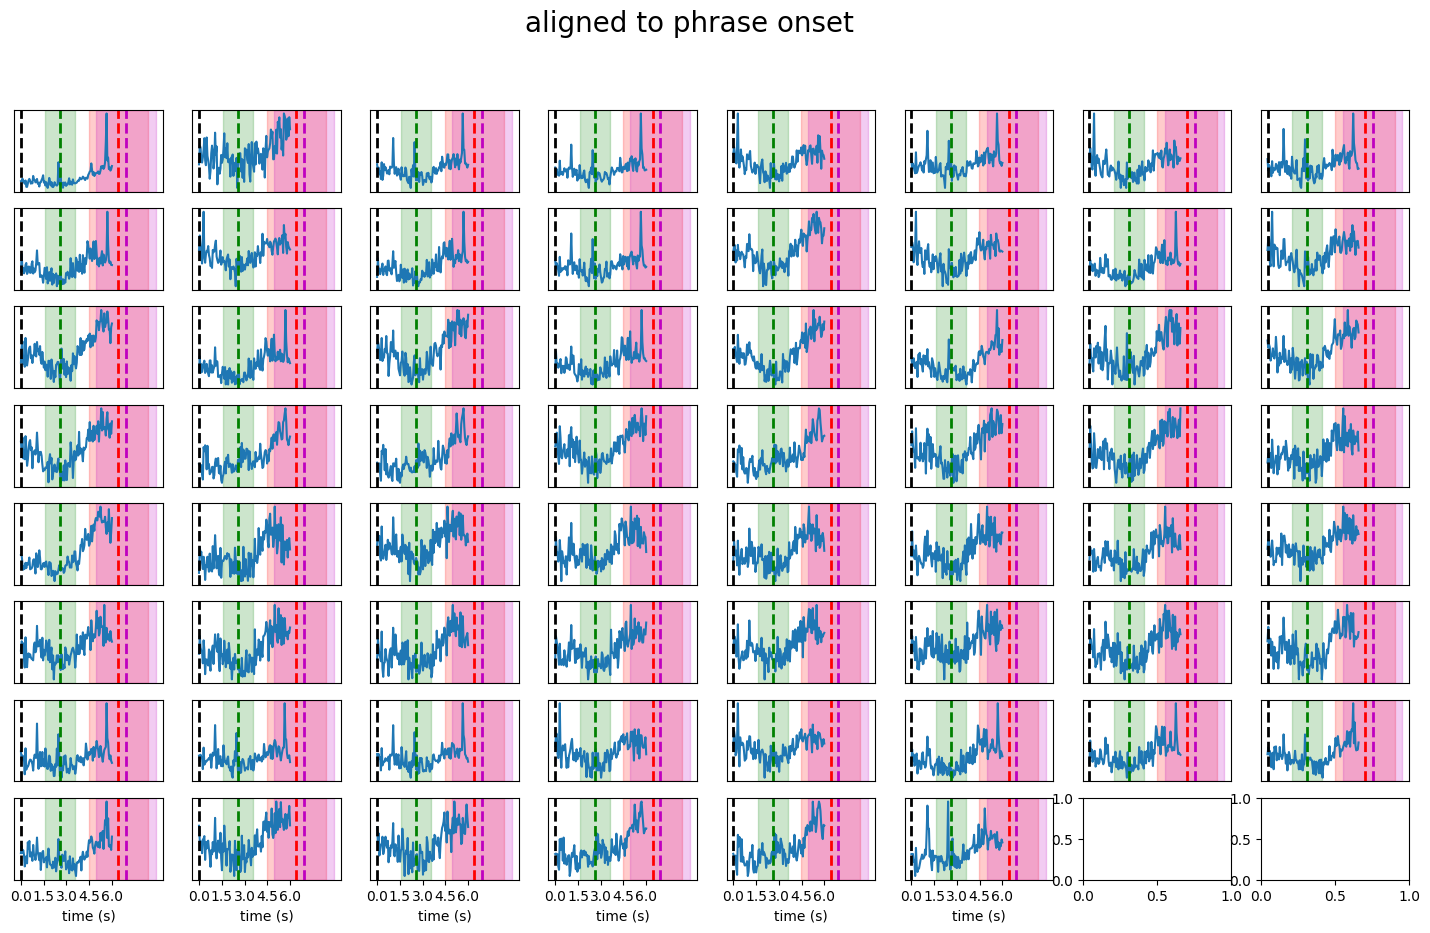

In [23]:
# # plotting trial-averaged data in aligning to the phrase onset. 1s before and 8s after
# 
# back=0 # looking back 3 seconds before onset
# forward=6 # looking forward 1 second after onset
# bin_size=0.05 # s
# adjusted_fs=1/bin_size # Hz
# processed_data_phrase_on=[trial[:,int(phrase_on[i]*fs-back*fs) : int(phrase_on[i]*fs+forward*fs)] for i,trial in enumerate(clean_data)]
# n_channels=processed_data_phrase_on[0].shape[0]
# n_trials_total=len(processed_data_phrase_on)
# binned_data_phrase_on=[trial.reshape(n_channels,int(bin_size*fs),-1,order='F').mean(axis=1) for trial in processed_data_phrase_on]
# binned_data_phrase_on_averaged=np.mean(binned_data_phrase_on,axis=0)
# n_bins=binned_data_phrase_on_averaged.shape[-1]
# 
# ave_phrase_on=back
# 
# ave_word_on=-(phrase_on-word_on).mean()+ave_phrase_on
# std_word_on=(phrase_on-word_on).std()
# 
# ave_voice_on=-(phrase_on-voice_on).mean()+ave_phrase_on
# std_voice_on=(phrase_on-voice_on).std()
# 
# ave_voice_off=-(phrase_on-voice_off).mean()+ave_phrase_on
# std_voice_off=(phrase_on-voice_off).std()
# 
# fig,ax=plt.subplots(8,8,figsize=(18,10))
# for i in range(n_channels):
#     ax[i//8,i%8].plot(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),binned_data_phrase_on_averaged[i])
#     ax[i//8,i%8].set_yticks([])
#     if i//8!=7:   
#         ax[i//8,i%8].set_xticks([])
#     else:
#         ax[i//8,i%8].set_xticks(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),5), [f"{i:0.1f}" for i in np.linspace(-back,forward,5)])
#         ax[i//8,i%8].set_xlabel("time (s)")
#     
#     ax[i//8,i%8].axvspan(ave_word_on * adjusted_fs - std_word_on * adjusted_fs, ave_word_on * adjusted_fs + std_word_on * adjusted_fs, color='g', alpha=0.2)
#     ax[i//8,i%8].axvspan(ave_voice_on * adjusted_fs - std_voice_on * adjusted_fs, ave_voice_on * adjusted_fs + std_voice_on * adjusted_fs, color='r', alpha=0.2)
#     ax[i//8,i%8].axvspan(ave_voice_off * adjusted_fs - std_voice_off * adjusted_fs, ave_voice_off * adjusted_fs + std_voice_off * adjusted_fs, color='m', alpha=0.2)
#     
#     ax[i//8,i%8].axvline(ave_phrase_on * adjusted_fs, color='k', linestyle='--', linewidth=2)
#     ax[i//8,i%8].axvline(ave_word_on * adjusted_fs, color='g', linestyle='--', linewidth=2)
#     ax[i//8,i%8].axvline(ave_voice_on * adjusted_fs, color='r', linestyle='--', linewidth=2)
#     ax[i//8,i%8].axvline(ave_voice_off * adjusted_fs, color='m', linestyle='--', linewidth=2)
# plt.suptitle("aligned to phrase onset",fontsize=20)
# plt.show()

In [24]:
# data_to_use=np.array(binned_data_phrase_on).swapaxes(1,2)
# embedding_to_use= PCA(n_components=50).fit_transform(np.array(word_embed))
# 
# # np.save(f"../Bolu_IFG/data_to_use.npy",data_to_use)
# # np.save(f"../Bolu_IFG/embedding_to_use.npy",embedding_to_use)

In [25]:
# # Here we are trying to do some regression task. It's shown that the dataset m
# preprocess_dim=40
# 
# ### preprocesing 
# preprocessor=PCA(n_components=preprocess_dim)
# 
# # define how many bins we want in each feature
# n_bins_per_feature=10
# 
# # reformat the data: for each time bin we include n_bins_per_feature of history
# X=reformat(data_to_use,n_bins_per_feature) # data is a list
# 
# #### Start decoding
# n_repeat=20
# averaged_score=[]
# averaged_chance=[]
# # GUI for process visualization
# manager = enlighten.get_manager()
# #ticks = manager.counter(total=n_repeat, desc="Num. repeat", unit="repeats", color="red")
# 
# for j in tqdm(range(n_repeat), desc='repeats', unit='rep.'):
#     score=[]
#     chance=[]
#     for n_bin in tqdm(range(len(X)),leave=False,desc='bins',unit='bin'):
#         # sample the train and test set
#         X_train, X_test, y_train, y_test =get_train_test(X[n_bin],embedding_to_use,train=0.8)
#         
#         # decrease the dimension
#         preprocessor.fit(X_train)
#         X_train_low_D=preprocessor.transform(X_train)
#         X_test_low_D=preprocessor.transform(X_test)
#         
# 
#         extractor=AlignmentNet(n_features=X_train_low_D.shape[1],
#                                n_targets=y_train.shape[1],n_low_D=5)  
#         
#         X_train_low_D=(X_train_low_D-np.mean(X_train_low_D))/np.std(X_train_low_D)
#         X_test_low_D=(X_test_low_D-np.mean(X_test_low_D))/np.std(X_test_low_D)
#         y_train=(y_train-np.mean(y_train))/np.std(y_train)
#         y_test=(y_test-np.mean(y_test))/np.std(y_test)
#         # do the regression(alignment)  
#         extractor.fit(X_train_low_D,y_train,lambda_l1=0.0002,num_iterations=200)
#         sc=extractor.score(X_test_low_D,y_test)
#         
#         np.random.shuffle(X_train_low_D.T)
#         np.random.shuffle(y_train.T)
#         extractor.fit(X_train_low_D,y_train,lambda_l1=0.0002,num_iterations=200)
#         ch=extractor.score(X_test_low_D,y_test)
#         
#         score.append(sc)
#         chance.append(ch)
#     #ticks.update()
#     averaged_score.append(score)
#     averaged_chance.append(chance)
#      
#      

repeats:  70%|███████   | 14/20 [57:32<24:39, 246.64s/rep.]


KeyboardInterrupt: 

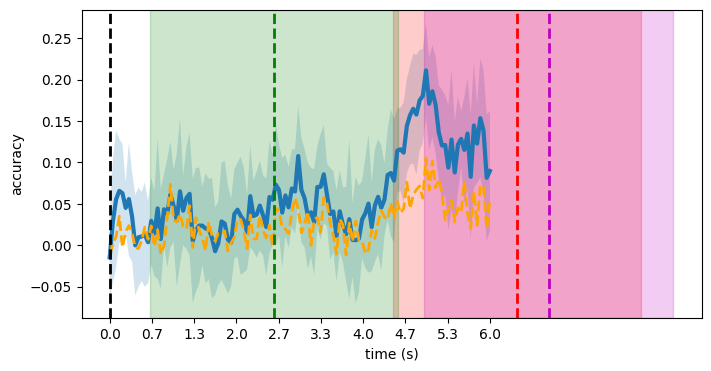

In [26]:
# fig,ax=plt.subplots(1,1,figsize=(8,4))
# ax.fill_between(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),
#                 np.mean(averaged_score,axis=0)-np.std(averaged_score,axis=0),
#                np.mean(averaged_score,axis=0)+np.std(averaged_score,axis=0),alpha=0.2)
# ax.plot(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),np.mean(averaged_score,axis=0),lw=3)
# ax.plot(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),np.mean(averaged_chance,axis=0),lw=2,linestyle='--',color='orange')
# #ax2=ax.twinx()
# #ax2.plot(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),binned_data_word_on_averaged.mean(axis=0),c='grey',linestyle='--')
# ax.axvspan(ave_voice_on * adjusted_fs - std_voice_on * adjusted_fs, ave_voice_on * adjusted_fs + std_voice_on * adjusted_fs, color='r', alpha=0.2)
# ax.axvspan(ave_voice_off * adjusted_fs - std_voice_off * adjusted_fs, ave_voice_off * adjusted_fs + std_voice_off * adjusted_fs, color='m', alpha=0.2)
# ax.axvspan(ave_word_on * adjusted_fs - std_phrase_on * adjusted_fs, ave_word_on * adjusted_fs + std_phrase_on * adjusted_fs, color='g', alpha=0.2)
# ax.axvline(ave_phrase_on * adjusted_fs, color='k', linestyle='--', linewidth=2)
# ax.axvline(ave_word_on * adjusted_fs, color='g', linestyle='--', linewidth=2)
# ax.axvline(ave_voice_on * adjusted_fs, color='r', linestyle='--', linewidth=2)
# ax.axvline(ave_voice_off * adjusted_fs, color='m', linestyle='--', linewidth=2)
# ax.set_xticks(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),10), [f"{i:0.1f}" for i in np.linspace(-back,forward,10)])
# #ax.set_ylim([0.3,0.7])
# ax.set_xlabel("time (s)")
# ax.set_ylabel("accuracy")
# #ax2.set_ylabel("zscored activity (a.u.)")
# plt.show()

### Here we would like to fix the word embedding 

In [9]:
data_to_use=np.array(binned_data_voice_on).swapaxes(1,2)
embedding_to_use= PCA(n_components=40).fit_transform(np.array(word_embed))

In [67]:
#n_bins_best_performance=np.argmax(np.mean(averaged_score,axis=0))
n_bins_best_performance=49
n_low=8
n_bins_per_feature=10
preprocess_dim=40
# run a model using that bin
X=reformat(data_to_use,n_bins_per_feature) # data is a list
X_best=X[n_bins_best_performance]

X_train, X_test, y_train, y_test,index_train,index_test=get_train_test(X_best,embedding_to_use,train=0.8)

preprocessor=PCA(n_components=preprocess_dim)
preprocessor.fit(X_train)
X_train_low_D=preprocessor.transform(X_train)       
X_test_low_D=preprocessor.transform(X_test)

extractor=AlignmentNet(n_features=X_train_low_D.shape[1],
                       n_targets=y_train.shape[1],n_low_D=n_low)  

X_train_low_D=(X_train_low_D-np.mean(X_train_low_D))/np.std(X_train_low_D)
X_test_low_D=(X_test_low_D-np.mean(X_test_low_D))/np.std(X_test_low_D)
y_train=(y_train-np.mean(y_train))/np.std(y_train)
y_test=(y_test-np.mean(y_test))/np.std(y_test)

extractor.fit(X_train_low_D,y_train,lambda_l1=0.001,num_iterations=200)

X_embed_test, y_embed_test=extractor.predict(X_test_low_D, y_test)
X_embed_train, y_embed_train=extractor.predict(X_train_low_D, y_train)
score=extractor.score(X_test_low_D,y_test)
print(score)

0.26633262634277344


In [68]:
linear_x=extractor.linear_X.weight.cpu().detach().numpy()
linear_y=extractor.linear_Y.weight.cpu().detach().numpy()
X_embed_train=X_embed_train.detach().cpu().numpy()
y_embed_train=y_embed_train.detach().cpu().numpy()
X_embed_test=X_embed_test.detach().cpu().numpy()
y_embed_test=y_embed_test.detach().cpu().numpy()


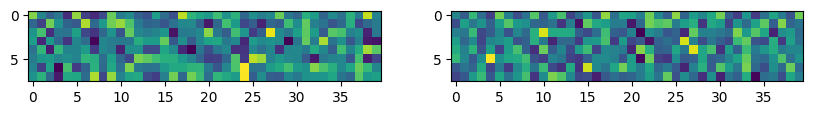

In [69]:
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(linear_x)
ax[1].imshow(linear_y)
plt.show()

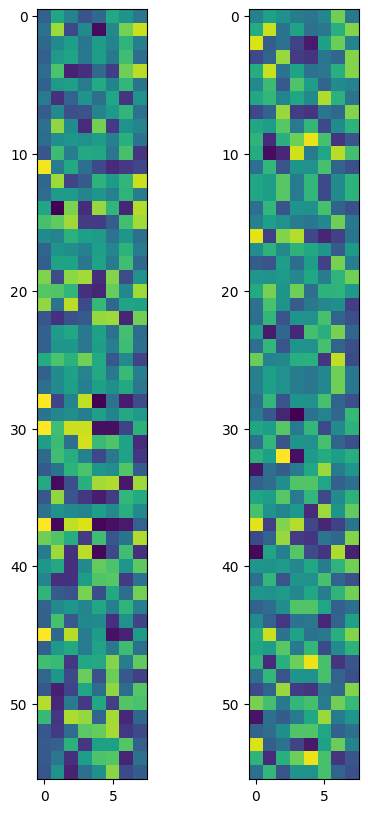

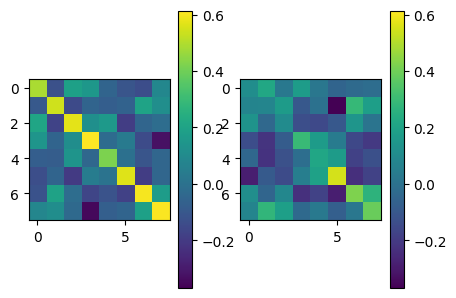

In [70]:
X_embed_test_zscore=(X_embed_test-X_embed_test.mean(axis=0))/X_embed_test.std(axis=0)
y_embed_test_zscore=(y_embed_test-y_embed_test.mean(axis=0))/y_embed_test.std(axis=0)

X_embed_train_zscore=(X_embed_train-X_embed_train.mean(axis=0))/X_embed_train.std(axis=0)
y_embed_train_zscore=(y_embed_train-y_embed_train.mean(axis=0))/y_embed_train.std(axis=0)

train_cov=np.cov(X_embed_train_zscore.T,y_embed_train_zscore.T)[:n_low,n_low:]
test_cov=np.cov(X_embed_test_zscore.T,y_embed_test_zscore.T)[:n_low,n_low:]

clim_max=np.max(np.array([train_cov,test_cov]))
clim_min=np.min(np.array([train_cov,test_cov]))

fig,ax=plt.subplots(1,2,figsize=(5,10))
ax[0].imshow(X_embed_test_zscore)
ax[1].imshow(y_embed_test_zscore)

fig,ax=plt.subplots(1,2,figsize=(5,12))
im=ax[0].imshow(train_cov)
im.set_clim(clim_min,clim_max)
plt.colorbar(im,shrink=0.3)
im=ax[1].imshow(test_cov)
im.set_clim(clim_min,clim_max)
plt.colorbar(im,shrink=0.3)
plt.show()

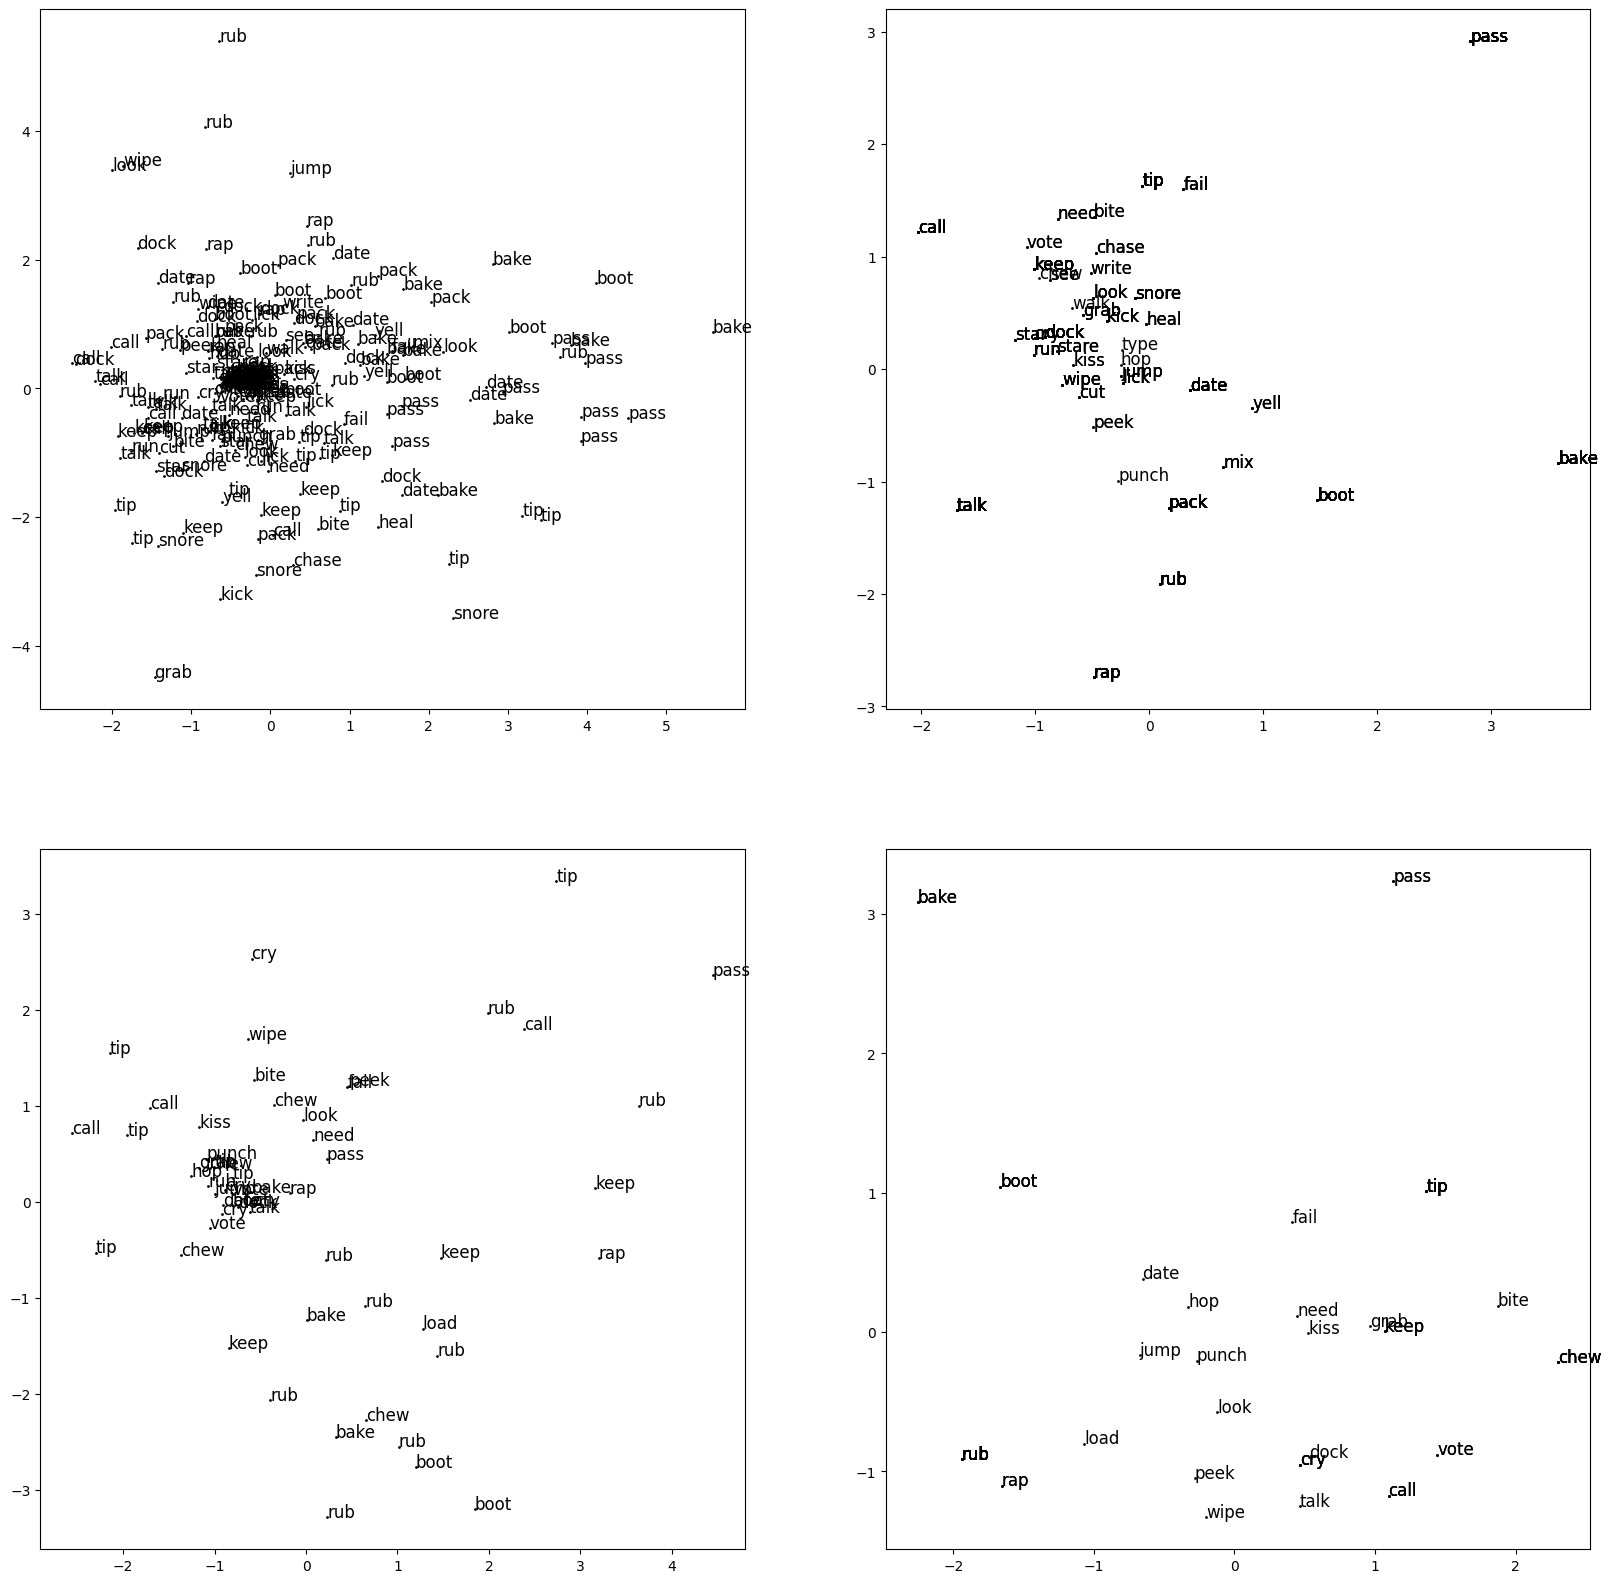

In [71]:
X_train_illustration=PCA(n_components=2).fit_transform(X_embed_train_zscore)
X_test_illustration=PCA(n_components=2).fit_transform(X_embed_test_zscore)
y_train_illustration=PCA(n_components=2).fit_transform(y_embed_train_zscore)
y_test_illustration=PCA(n_components=2).fit_transform(y_embed_test_zscore)

fig,ax=plt.subplots(2,2,figsize=(20,20))
for i,w in enumerate(X_train_illustration):
    ax[0][0].scatter(w[0],w[1],color='k',s=1)
    ax[0][0].text(w[0],w[1],answered_lexical_item[index_train[i]],fontsize=12)
for i,w in enumerate(y_train_illustration):
    ax[0][1].scatter(w[0],w[1],color='k',s=1)
    ax[0][1].text(w[0],w[1],answered_lexical_item[index_train[i]],fontsize=12)
    
for i,w in enumerate(X_test_illustration):
    ax[1][0].scatter(w[0],w[1],color='k',s=1)
    ax[1][0].text(w[0],w[1],answered_lexical_item[index_test[i]],fontsize=12)
for i,w in enumerate(y_test_illustration):
    ax[1][1].scatter(w[0],w[1],color='k',s=1)
    ax[1][1].text(w[0],w[1],answered_lexical_item[index_test[i]],fontsize=12)
plt.show()